In [ ]:
"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                 BraTS20 nnFormer - Complete Kaggle Solution                  ║
║          3D Brain Tumor Segmentation + Classification with Transformers      ║
║                                                                              ║
║  Dataset: BraTS20 (awsaf49/brats20-dataset-training-validation)             ║
║  Task: Segment tumors (3 classes) + Classify survival (2 classes)           ║
║  Copy this entire script into a Kaggle notebook and run!                    ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

# ============================================================================
# INSTALLATION & SETUP
# ============================================================================
import sys
!{sys.executable} -m pip install -q einops nibabel > /dev/null

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, gc, warnings, glob
from pathlib import Path
import nibabel as nib
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")


# ============================================================================
# MODEL ARCHITECTURE (Compact & Efficient)
# ============================================================================

class Attn3D(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.heads, self.scale = heads, (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Sequential(nn.Linear(dim, dim), nn.Dropout(dropout))
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1) * self.scale).softmax(-1)
        return self.proj((attn @ v).transpose(1, 2).reshape(B, N, C))


class TBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.norm1, self.norm2 = nn.LayerNorm(dim), nn.LayerNorm(dim)
        self.attn = Attn3D(dim, heads)
        self.mlp = nn.Sequential(nn.Linear(dim, dim*2), nn.GELU(), 
                                nn.Dropout(0.1), nn.Linear(dim*2, dim))
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        return x + self.mlp(self.norm2(x))


class Conv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1), nn.InstanceNorm3d(out_ch), 
            nn.LeakyReLU(0.01, True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1), nn.InstanceNorm3d(out_ch), 
            nn.LeakyReLU(0.01, True))
    
    def forward(self, x): return self.conv(x)


class nnFormer(nn.Module):
    def __init__(self, in_ch=4, seg_classes=4, clf_classes=2, base=24, depths=[1,1,1,1]):
        super().__init__()
        self.stem = Conv3D(in_ch, base)
        ch = [base, base*2, base*4, base*8]
        
        # Encoder
        self.enc, self.down = nn.ModuleList(), nn.ModuleList()
        for i in range(4):
            enc = nn.ModuleList([Conv3D(ch[i], ch[i])])
            if i >= 2:  # Transformers only in deep layers
                enc.extend([TBlock(ch[i], [2,4,8,8][i]) for _ in range(depths[i])])
            self.enc.append(enc)
            if i < 3: self.down.append(nn.Conv3d(ch[i], ch[i+1], 2, 2))
        
        # Decoder
        self.up = nn.ModuleList([nn.ConvTranspose3d(ch[3], ch[2], 2, 2),
                                nn.ConvTranspose3d(ch[2], ch[1], 2, 2),
                                nn.ConvTranspose3d(ch[1], ch[0], 2, 2)])
        self.dec = nn.ModuleList([Conv3D(ch[2]*2, ch[2]), Conv3D(ch[1]*2, ch[1]), 
                                 Conv3D(ch[0]*2, ch[0])])
        
        # Heads
        self.seg_head = nn.Conv3d(base, seg_classes, 1)
        self.clf_head = nn.Sequential(nn.AdaptiveAvgPool3d(1), nn.Flatten(),
                                     nn.Linear(ch[3], 128), nn.GELU(), 
                                     nn.Dropout(0.3), nn.Linear(128, clf_classes))
    
    def forward(self, x):
        x = self.stem(x)
        skips = []
        
        # Encode
        for i, blocks in enumerate(self.enc):
            for blk in blocks:
                if isinstance(blk, Conv3D):
                    x = blk(x)
                else:  # Transformer
                    B, C, D, H, W = x.shape
                    x = blk(x.flatten(2).transpose(1,2)).transpose(1,2).reshape(B,C,D,H,W)
            skips.append(x)
            if i < 3: x = self.down[i](x)
        
        clf = self.clf_head(x)
        
        # Decode
        for i, (up, conv) in enumerate(zip(self.up, self.dec)):
            x = conv(torch.cat([up(x), skips[-(i+2)]], 1))
        
        return self.seg_head(x), clf


# ============================================================================
# DATA LOADING FOR BRATS20
# ============================================================================

class BraTS20Dataset(Dataset):
    """
    BraTS20 Dataset Loader
    
    Directory structure expected:
    /kaggle/input/brats20-dataset-training-validation/
        ├── BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/
        │   ├── BraTS20_Training_001/
        │   │   ├── BraTS20_Training_001_flair.nii
        │   │   ├── BraTS20_Training_001_t1.nii
        │   │   ├── BraTS20_Training_001_t1ce.nii
        │   │   ├── BraTS20_Training_001_t2.nii
        │   │   └── BraTS20_Training_001_seg.nii
        │   └── ...
        └── BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/
            └── ...
    
    Modalities: FLAIR, T1, T1ce, T2 (4 channels)
    Segmentation classes: 0=background, 1=necrotic, 2=edema, 4=enhancing
    """
    
    def __init__(self, patient_dirs, img_size=128, mode='train', augment=False):
        self.patient_dirs = patient_dirs
        self.img_size = img_size
        self.mode = mode
        self.augment = augment
    
    def __len__(self):
        return len(self.patient_dirs)
    
    def load_nifti(self, filepath):
        """Load NIfTI file and return numpy array"""
        return nib.load(filepath).get_fdata().astype(np.float32)
    
    def normalize(self, img):
        """Normalize image per channel"""
        for c in range(img.shape[0]):
            channel = img[c]
            if channel.max() > 0:
                img[c] = (channel - channel.mean()) / (channel.std() + 1e-8)
        return img
    
    def resize_volume(self, volume, target_shape):
        """Simple resize using center crop or pad"""
        current_shape = volume.shape
        output = np.zeros(target_shape, dtype=volume.dtype)
        
        # Calculate crop/pad indices
        slices = []
        for curr, tgt in zip(current_shape, target_shape):
            if curr >= tgt:
                # Crop
                start = (curr - tgt) // 2
                slices.append(slice(start, start + tgt))
            else:
                # Will pad
                slices.append(slice(None))
        
        # Extract cropped region
        cropped = volume[tuple(slices)]
        
        # Calculate padding
        pad_widths = []
        for curr, tgt in zip(cropped.shape, target_shape):
            diff = tgt - curr
            pad_widths.append((diff // 2, diff - diff // 2))
        
        # Pad if necessary
        if any(sum(p) > 0 for p in pad_widths):
            output = np.pad(cropped, pad_widths, mode='constant', constant_values=0)
        else:
            output = cropped
            
        return output
    
    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        patient_id = os.path.basename(patient_dir)
        
        # Load all 4 modalities
        modalities = ['flair', 't1', 't1ce', 't2']
        img_channels = []
        
        for mod in modalities:
            filepath = os.path.join(patient_dir, f"{patient_id}_{mod}.nii")
            if not os.path.exists(filepath):
                filepath = filepath.replace('.nii', '.nii.gz')
            
            channel = self.load_nifti(filepath)
            channel = self.resize_volume(channel, (self.img_size, self.img_size, self.img_size))
            img_channels.append(channel)
        
        # Stack channels (4, D, H, W)
        img = np.stack(img_channels, axis=0)
        img = self.normalize(img)
        
        # Load segmentation mask
        seg_path = os.path.join(patient_dir, f"{patient_id}_seg.nii")
        if not os.path.exists(seg_path):
            seg_path = seg_path.replace('.nii', '.nii.gz')
        
        if os.path.exists(seg_path):
            mask = self.load_nifti(seg_path)
            mask = self.resize_volume(mask, (self.img_size, self.img_size, self.img_size))
            
            # BraTS labels: 0=background, 1=necrotic, 2=edema, 4=enhancing
            # Convert to: 0=background, 1=necrotic, 2=edema, 3=enhancing
            mask[mask == 4] = 3
            mask = mask.astype(np.int64)
            
            # Classification label: has tumor (any non-zero) = 1, no tumor = 0
            has_tumor = int((mask > 0).sum() > 100)  # threshold to avoid noise
        else:
            # Validation set without masks
            mask = np.zeros((self.img_size, self.img_size, self.img_size), dtype=np.int64)
            has_tumor = 0
        
        # Simple augmentation
        if self.augment and self.mode == 'train':
            if np.random.rand() > 0.5:  # Random flip
                axis = np.random.randint(1, 4)  # Don't flip channel axis
                img = np.flip(img, axis).copy()
                mask = np.flip(mask, axis).copy()
        
        return (torch.from_numpy(img).float(), 
                torch.from_numpy(mask).long(), 
                torch.tensor(has_tumor).long())


def prepare_brats_data(data_dir, train_split=0.8, img_size=128):
    """
    Prepare BraTS20 dataset
    Returns train and validation datasets
    """
    # Find all patient directories
    train_base = os.path.join(data_dir, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')
    
    if not os.path.exists(train_base):
        print(f"❌ Error: Directory not found: {train_base}")
        print(f"Available directories in {data_dir}:")
        if os.path.exists(data_dir):
            for item in os.listdir(data_dir):
                print(f"  - {item}")
        return None, None
    
    patient_dirs = sorted([d for d in glob.glob(os.path.join(train_base, 'BraTS20_*')) 
                          if os.path.isdir(d)])
    
    print(f"📁 Found {len(patient_dirs)} patients")
    
    if len(patient_dirs) == 0:
        print("❌ No patient directories found!")
        return None, None
    
    # Split into train/val
    train_dirs, val_dirs = train_test_split(patient_dirs, train_size=train_split, 
                                            random_state=42)
    
    print(f"   Train: {len(train_dirs)} patients")
    print(f"   Val: {len(val_dirs)} patients")
    
    # Create datasets
    train_ds = BraTS20Dataset(train_dirs, img_size=img_size, mode='train', augment=True)
    val_ds = BraTS20Dataset(val_dirs, img_size=img_size, mode='val', augment=False)
    
    return train_ds, val_ds


# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        pred = F.softmax(pred, 1)
        target_oh = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
        inter = (pred * target_oh).sum((0,2,3,4))
        union = (pred + target_oh).sum((0,2,3,4))
        return 1 - (2*inter + 1) / (union + 1)


class CombinedLoss(nn.Module):
    """Dice + Cross Entropy for better gradients"""
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.ce = nn.CrossEntropyLoss()
    
    def forward(self, pred, target):
        return self.dice(pred, target).mean() + 0.5 * self.ce(pred, target)


def metrics(seg_pred, seg_true, clf_pred, clf_true):
    seg_pred = seg_pred.argmax(1)
    dice_scores = []
    for c in range(seg_pred.max().item() + 1):
        pred_c = (seg_pred == c)
        true_c = (seg_true == c)
        inter = (pred_c & true_c).sum().float()
        union = (pred_c | true_c).sum().float()
        dice_c = (2 * inter / (union + 1e-8)).item()
        dice_scores.append(dice_c)
    
    acc = (clf_pred.argmax(1) == clf_true).float().mean().item()
    return {'dice': np.mean(dice_scores), 'acc': acc}


def train_epoch(model, loader, seg_crit, clf_crit, opt, scaler):
    model.train()
    total = {'loss': 0, 'dice': 0, 'acc': 0}
    
    pbar = tqdm(loader, desc='Train', leave=False)
    for imgs, masks, labels in pbar:
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
        
        with autocast():
            seg_pred, clf_pred = model(imgs)
            loss = seg_crit(seg_pred, masks) + 0.5 * clf_crit(clf_pred, labels)
        
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
        
        m = metrics(seg_pred.detach(), masks, clf_pred.detach(), labels)
        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']
        
        pbar.set_postfix({'loss': f"{loss.item():.3f}", 'dice': f"{m['dice']:.3f}"})
    
    return {k: v/len(loader) for k,v in total.items()}


@torch.no_grad()
def val_epoch(model, loader, seg_crit, clf_crit):
    model.eval()
    total = {'loss': 0, 'dice': 0, 'acc': 0}
    
    for imgs, masks, labels in tqdm(loader, desc='Val', leave=False):
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
        seg_pred, clf_pred = model(imgs)
        loss = seg_crit(seg_pred, masks) + 0.5 * clf_crit(clf_pred, labels)
        
        m = metrics(seg_pred, masks, clf_pred, labels)
        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']
    
    return {k: v/len(loader) for k,v in total.items()}


# ============================================================================
# MAIN TRAINING
# ============================================================================

# CONFIG - Optimized for BraTS20 on Kaggle T4 GPU
CFG = {
    'img_size': 128,      # Volume size (128³ works well for T4, reduce to 96 if OOM)
    'seg_classes': 4,     # BraTS: background, necrotic, edema, enhancing
    'clf_classes': 2,     # Has tumor or not
    'base_ch': 24,        # Base channels (24=lightweight, increase if memory allows)
    'depths': [1,1,2,2],  # Transformer blocks per stage
    'batch_size': 2,      # Batch size (increase to 4 if memory allows)
    'epochs': 50,         # Training epochs
    'lr': 1e-3,           # Learning rate
    'train_split': 0.85,  # Train/val split
}

print(f"\n{'='*80}")
print(f"📋 CONFIGURATION")
print(f"{'='*80}")
for k, v in CFG.items():
    print(f"   {k:15s}: {v}")
print(f"{'='*80}\n")

# DATA LOADING
print("📂 Loading BraTS20 dataset...")
data_dir = '/kaggle/input/brats20-dataset-training-validation'

train_ds, val_ds = prepare_brats_data(data_dir, CFG['train_split'], CFG['img_size'])

if train_ds is None:
    print("\n❌ Failed to load dataset. Please check the data directory path.")
    print(f"Expected: {data_dir}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/")
else:
    train_loader = DataLoader(train_ds, CFG['batch_size'], shuffle=True, 
                             num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, CFG['batch_size'], shuffle=False, 
                           num_workers=2, pin_memory=True)
    
    print(f"\n✅ Dataset loaded successfully!")
    print(f"   Batch size: {CFG['batch_size']}")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}\n")
    
    # MODEL
    model = nnFormer(
        in_ch=4,  # 4 MRI modalities
        seg_classes=CFG['seg_classes'], 
        clf_classes=CFG['clf_classes'], 
        base=CFG['base_ch'], 
        depths=CFG['depths']
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"💪 Model initialized")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / 1e6:.1f} MB\n")
    
    # TRAINING SETUP
    seg_crit = CombinedLoss()
    clf_crit = nn.CrossEntropyLoss()
    opt = optim.AdamW(model.parameters(), CFG['lr'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, CFG['epochs'])
    scaler = GradScaler()
    
    # TRAINING LOOP
    history = {'train': [], 'val': []}
    best_dice = 0
    
    print(f"{'='*80}")
    print("🚀 STARTING TRAINING")
    print(f"{'='*80}\n")
    
    for epoch in range(1, CFG['epochs']+1):
        train_m = train_epoch(model, train_loader, seg_crit, clf_crit, opt, scaler)
        val_m = val_epoch(model, val_loader, seg_crit, clf_crit)
        scheduler.step()
        
        history['train'].append(train_m)
        history['val'].append(val_m)
        
        print(f"Epoch {epoch:3d}/{CFG['epochs']} | "
              f"Train: L={train_m['loss']:.4f} D={train_m['dice']:.4f} A={train_m['acc']:.4f} | "
              f"Val: L={val_m['loss']:.4f} D={val_m['dice']:.4f} A={val_m['acc']:.4f}")
        
        # Save best model
        if val_m['dice'] > best_dice:
            best_dice = val_m['dice']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'cfg': CFG,
                'dice': best_dice,
                'history': history
            }, 'best_brats_model.pth')
            print(f"   ✅ Best model saved! (Dice: {best_dice:.4f})")
        
        # Memory cleanup
        if epoch % 5 == 0:
            gc.collect()
            torch.cuda.empty_cache()
    
    print(f"\n{'='*80}")
    print(f"✅ TRAINING COMPLETE!")
    print(f"   Best Validation Dice: {best_dice:.4f}")
    print(f"{'='*80}\n")
    
    
    # ============================================================================
    # VISUALIZATION
    # ============================================================================
    
    print("📊 Generating visualizations...\n")
    
    # Plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train'])+1)
    
    # Loss
    axes[0].plot(epochs, [m['loss'] for m in history['train']], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, [m['loss'] for m in history['val']], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Curves', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Dice Score
    axes[1].plot(epochs, [m['dice'] for m in history['train']], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, [m['dice'] for m in history['val']], 'r-', label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Dice Score', fontsize=12)
    axes[1].set_title('Dice Score', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Accuracy
    axes[2].plot(epochs, [m['acc'] for m in history['train']], 'b-', label='Train', linewidth=2)
    axes[2].plot(epochs, [m['acc'] for m in history['val']], 'r-', label='Val', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Classification Accuracy', fontsize=12)
    axes[2].set_title('Classification Accuracy', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('brats_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Visualize predictions
    model.eval()
    img, mask, label = val_ds[0]
    
    with torch.no_grad():
        seg_pred, clf_pred = model(img.unsqueeze(0).to(device))
        seg_pred = seg_pred.argmax(1)[0].cpu().numpy()
        clf_pred = clf_pred.argmax(1)[0].item()
    
    # Show middle slices
    mid = CFG['img_size'] // 2
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Row 1: Input modalities
    modality_names = ['FLAIR', 'T1', 'T1ce', 'T2']
    for i, name in enumerate(modality_names):
        axes[0, i].imshow(img[i, mid].numpy(), cmap='gray')
        axes[0, i].set_title(f'{name}', fontsize=14, fontweight='bold')
        axes[0, i].axis('off')
    
    # Row 2: Ground truth, Prediction, Overlay
    axes[1, 0].imshow(mask[mid].numpy(), cmap='jet', vmin=0, vmax=3)
    axes[1, 0].set_title(f'Ground Truth\n(Label: {label.item()})', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(seg_pred[mid], cmap='jet', vmin=0, vmax=3)
    axes[1, 1].set_title(f'Prediction\n(Pred: {clf_pred})', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Overlay on FLAIR
    axes[1, 2].imshow(img[0, mid].numpy(), cmap='gray')
    axes[1, 2].imshow(seg_pred[mid], cmap='jet', alpha=0.5, vmin=0, vmax=3)
    axes[1, 2].set_title('Prediction Overlay', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')
    
    # Legend
    axes[1, 3].axis('off')
    legend_text = "Segmentation Classes:\n\n"
    legend_text += "0 = Background (Black)\n"
    legend_text += "1 = Necrotic Core (Blue)\n"
    legend_text += "2 = Edema (Green)\n"
    legend_text += "3 = Enhancing (Red)\n\n"
    legend_text += f"Dice Score: {best_dice:.4f}"
    axes[1, 3].text(0.1, 0.5, legend_text, fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('brats_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizations saved!")
    print(f"   - brats_training_curves.png")
    print(f"   - brats_predictions.png")
    
    
    # ============================================================================
    # INFERENCE FUNCTION
    # ============================================================================
    
    @torch.no_grad()
    def predict_patient(model, patient_dir, img_size=128):
        """Predict segmentation for a single patient"""
        model.eval()
        
        # Load patient (same as dataset)
        patient_id = os.path.basename(patient_dir)
        modalities = ['flair', 't1', 't1ce', 't2']
        img_channels = []
        
        for mod in modalities:
            filepath = os.path.join(patient_dir, f"{patient_id}_{mod}.nii")
            if not os.path.exists(filepath):
                filepath = filepath.replace('.nii', '.nii.gz')
            
            channel = nib.load(filepath).get_fdata().astype(np.float32)
            # Resize (use same function as dataset)
            channel = val_ds.resize_volume(channel, (img_size, img_size, img_size))
            img_channels.append(channel)
        
        img = np.stack(img_channels, axis=0)
        
        # Normalize
        for c in range(img.shape[0]):
            channel = img[c]
            if channel.max() > 0:
                img[c] = (channel - channel.mean()) / (channel.std() + 1e-8)
        
        # Predict
        img_tensor = torch.from_numpy(img).unsqueeze(0).float().to(device)
        seg_pred, clf_pred = model(img_tensor)
        
        seg_pred = seg_pred.argmax(1)[0].cpu().numpy()
        clf_pred = clf_pred.argmax(1)[0].cpu().item()
        
        # Convert back to BraTS labels (0,1,2,3 -> 0,1,2,4)
        seg_pred[seg_pred == 3] = 4
        
        return seg_pred, clf_pred
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE - MODEL READY FOR INFERENCE!")
    print("="*80)
    print("\n📝 Usage example:")
    print("   seg_mask, has_tumor = predict_patient(model, '/path/to/patient/dir')")
    print("\n💾 Model saved as: best_brats_model.pth")
    print("🏆 Best Validation Dice Score: {:.4f}".format(best_dice))

In [ ]:
"""
╔══════════════════════════════════════════════════════════════════════════════╗
║              BraTS20 nnFormer - MEMORY OPTIMIZED for Kaggle T4               ║
║          3D Brain Tumor Segmentation - Optimized for 16GB GPU                ║
║                                                                              ║
║  Optimizations: Smaller volumes, gradient checkpointing, efficient loading  ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

# ============================================================================
# INSTALLATION & SETUP
# ============================================================================
import sys
!{sys.executable} -m pip install -q einops nibabel > /dev/null

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, gc, warnings, glob
from pathlib import Path
import nibabel as nib
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")
    # Clear cache at start
    torch.cuda.empty_cache()


# ============================================================================
# LIGHTWEIGHT MODEL ARCHITECTURE
# ============================================================================

class Attn3D(nn.Module):
    """Memory-efficient 3D attention"""
    def __init__(self, dim, heads=2, dropout=0.1):  # Reduced heads
        super().__init__()
        self.heads, self.scale = heads, (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)  # No bias to save memory
        self.proj = nn.Sequential(nn.Linear(dim, dim, bias=False), nn.Dropout(dropout))
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1) * self.scale).softmax(-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        del qkv, q, k, v, attn  # Explicit cleanup
        return self.proj(out)


class TBlock(nn.Module):
    """Transformer block with gradient checkpointing support"""
    def __init__(self, dim, heads=2):
        super().__init__()
        self.norm1, self.norm2 = nn.LayerNorm(dim), nn.LayerNorm(dim)
        self.attn = Attn3D(dim, heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*2, bias=False), 
            nn.GELU(), 
            nn.Dropout(0.1), 
            nn.Linear(dim*2, dim, bias=False)
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class Conv3D(nn.Module):
    """Lightweight 3D conv block"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch), 
            nn.LeakyReLU(0.01, True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch), 
            nn.LeakyReLU(0.01, True)
        )
    
    def forward(self, x): 
        return self.conv(x)


class nnFormerLite(nn.Module):
    """Memory-optimized nnFormer"""
    def __init__(self, in_ch=4, seg_classes=4, clf_classes=2, base=16, depths=[1,1,1,1]):
        super().__init__()
        self.stem = Conv3D(in_ch, base)
        ch = [base, base*2, base*4, base*8]  # 16,32,64,128
        
        # Encoder
        self.enc, self.down = nn.ModuleList(), nn.ModuleList()
        for i in range(4):
            enc = nn.ModuleList([Conv3D(ch[i], ch[i])])
            # Only add transformers in the deepest layer
            if i == 3 and depths[i] > 0:  # Only at bottleneck
                enc.extend([TBlock(ch[i], heads=2) for _ in range(depths[i])])
            self.enc.append(enc)
            if i < 3: 
                self.down.append(nn.Conv3d(ch[i], ch[i+1], 2, 2, bias=False))
        
        # Decoder
        self.up = nn.ModuleList([
            nn.ConvTranspose3d(ch[3], ch[2], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[2], ch[1], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[1], ch[0], 2, 2, bias=False)
        ])
        self.dec = nn.ModuleList([
            Conv3D(ch[2]*2, ch[2]), 
            Conv3D(ch[1]*2, ch[1]), 
            Conv3D(ch[0]*2, ch[0])
        ])
        
        # Heads
        self.seg_head = nn.Conv3d(base, seg_classes, 1)
        self.clf_head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), 
            nn.Flatten(),
            nn.Linear(ch[3], 64, bias=False),
            nn.GELU(), 
            nn.Dropout(0.3), 
            nn.Linear(64, clf_classes, bias=False)
        )
    
    def forward(self, x):
        x = self.stem(x)
        skips = []
        
        # Encode
        for i, blocks in enumerate(self.enc):
            for blk in blocks:
                if isinstance(blk, Conv3D):
                    x = blk(x)
                else:  # Transformer
                    B, C, D, H, W = x.shape
                    x_flat = x.flatten(2).transpose(1, 2)
                    x_flat = blk(x_flat)
                    x = x_flat.transpose(1, 2).reshape(B, C, D, H, W)
                    del x_flat
            skips.append(x)
            if i < 3: 
                x = self.down[i](x)
        
        clf = self.clf_head(x)
        
        # Decode
        for i, (up, conv) in enumerate(zip(self.up, self.dec)):
            x = up(x)
            skip = skips[-(i+2)]
            x = conv(torch.cat([x, skip], 1))
            del skip
        
        seg = self.seg_head(x)
        return seg, clf


# ============================================================================
# MEMORY-EFFICIENT DATA LOADING
# ============================================================================

class BraTS20Lite(Dataset):
    """Memory-optimized BraTS20 loader with on-the-fly preprocessing"""
    
    def __init__(self, patient_dirs, img_size=96, mode='train', augment=False):
        self.patient_dirs = patient_dirs
        self.img_size = img_size
        self.mode = mode
        self.augment = augment
    
    def __len__(self):
        return len(self.patient_dirs)
    
    def load_nifti(self, filepath):
        """Load NIfTI - use float16 to save memory during loading"""
        data = nib.load(filepath).get_fdata()
        return data.astype(np.float32)  # Convert at the end
    
    def normalize(self, img):
        """Normalize per channel - in-place to save memory"""
        for c in range(img.shape[0]):
            channel = img[c]
            if channel.max() > 0:
                mean, std = channel.mean(), channel.std()
                img[c] = (channel - mean) / (std + 1e-8)
        return img
    
    def resize_volume(self, volume, target_shape):
        """Center crop or pad"""
        current_shape = volume.shape
        output = np.zeros(target_shape, dtype=volume.dtype)
        
        slices = []
        for curr, tgt in zip(current_shape, target_shape):
            if curr >= tgt:
                start = (curr - tgt) // 2
                slices.append(slice(start, start + tgt))
            else:
                slices.append(slice(None))
        
        cropped = volume[tuple(slices)]
        
        pad_widths = []
        for curr, tgt in zip(cropped.shape, target_shape):
            diff = tgt - curr
            pad_widths.append((diff // 2, diff - diff // 2))
        
        if any(sum(p) > 0 for p in pad_widths):
            output = np.pad(cropped, pad_widths, mode='constant', constant_values=0)
        else:
            output = cropped
            
        return output
    
    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        patient_id = os.path.basename(patient_dir)
        
        # Load modalities one by one to save memory
        modalities = ['flair', 't1', 't1ce', 't2']
        img_channels = []
        
        for mod in modalities:
            filepath = os.path.join(patient_dir, f"{patient_id}_{mod}.nii")
            if not os.path.exists(filepath):
                filepath = filepath.replace('.nii', '.nii.gz')
            
            channel = self.load_nifti(filepath)
            channel = self.resize_volume(channel, (self.img_size, self.img_size, self.img_size))
            img_channels.append(channel)
        
        img = np.stack(img_channels, axis=0)
        del img_channels  # Free memory
        img = self.normalize(img)
        
        # Load mask
        seg_path = os.path.join(patient_dir, f"{patient_id}_seg.nii")
        if not os.path.exists(seg_path):
            seg_path = seg_path.replace('.nii', '.nii.gz')
        
        if os.path.exists(seg_path):
            mask = self.load_nifti(seg_path)
            mask = self.resize_volume(mask, (self.img_size, self.img_size, self.img_size))
            mask[mask == 4] = 3  # Remap labels
            mask = mask.astype(np.int64)
            has_tumor = int((mask > 0).sum() > 50)
        else:
            mask = np.zeros((self.img_size, self.img_size, self.img_size), dtype=np.int64)
            has_tumor = 0
        
        # Simple augmentation
        if self.augment and self.mode == 'train' and np.random.rand() > 0.5:
            # img has shape (4, D, H, W) - can flip axes 1, 2, 3
            # mask has shape (D, H, W) - can flip axes 0, 1, 2
            axis_img = np.random.randint(1, 4)  # For image: 1, 2, or 3
            axis_mask = axis_img - 1  # For mask: 0, 1, or 2
            img = np.flip(img, axis_img).copy()
            mask = np.flip(mask, axis_mask).copy()
        
        return (
            torch.from_numpy(img).float(), 
            torch.from_numpy(mask).long(), 
            torch.tensor(has_tumor).long()
        )


def prepare_brats_data(data_dir, train_split=0.85, img_size=96, max_patients=None):
    """Prepare BraTS20 with option to limit dataset size"""
    train_base = os.path.join(data_dir, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')
    
    if not os.path.exists(train_base):
        print(f"❌ Error: Directory not found: {train_base}")
        return None, None
    
    patient_dirs = sorted([d for d in glob.glob(os.path.join(train_base, 'BraTS20_*')) 
                          if os.path.isdir(d)])
    
    # Limit dataset size if specified (useful for testing)
    if max_patients:
        patient_dirs = patient_dirs[:max_patients]
    
    print(f"📁 Found {len(patient_dirs)} patients")
    
    if len(patient_dirs) == 0:
        return None, None
    
    train_dirs, val_dirs = train_test_split(patient_dirs, train_size=train_split, random_state=42)
    
    print(f"   Train: {len(train_dirs)} patients")
    print(f"   Val: {len(val_dirs)} patients")
    
    train_ds = BraTS20Lite(train_dirs, img_size=img_size, mode='train', augment=True)
    val_ds = BraTS20Lite(val_dirs, img_size=img_size, mode='val', augment=False)
    
    return train_ds, val_ds


# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        pred = F.softmax(pred, 1)
        target_oh = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
        inter = (pred * target_oh).sum((0,2,3,4))
        union = (pred + target_oh).sum((0,2,3,4))
        dice = (2*inter + 1) / (union + 1)
        return 1 - dice.mean()


def metrics(seg_pred, seg_true, clf_pred, clf_true):
    with torch.no_grad():
        seg_pred = seg_pred.argmax(1)
        dice_scores = []
        for c in range(4):
            pred_c = (seg_pred == c)
            true_c = (seg_true == c)
            inter = (pred_c & true_c).sum().float()
            union = (pred_c | true_c).sum().float()
            dice_c = (2 * inter / (union + 1e-8)).item()
            dice_scores.append(dice_c)
        
        acc = (clf_pred.argmax(1) == clf_true).float().mean().item()
        return {'dice': np.mean(dice_scores), 'acc': acc}


def train_epoch(model, loader, seg_crit, clf_crit, opt, scaler):
    model.train()
    total = {'loss': 0, 'dice': 0, 'acc': 0}
    
    pbar = tqdm(loader, desc='Train', leave=False)
    for imgs, masks, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        opt.zero_grad(set_to_none=True)  # More memory efficient
        
        with autocast():
            seg_pred, clf_pred = model(imgs)
            loss = seg_crit(seg_pred, masks) + 0.3 * clf_crit(clf_pred, labels)
        
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        
        with torch.no_grad():
            m = metrics(seg_pred, masks, clf_pred, labels)
        
        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']
        
        pbar.set_postfix({'loss': f"{loss.item():.3f}", 'dice': f"{m['dice']:.3f}"})
        
        # Clear cache periodically
        del imgs, masks, labels, seg_pred, clf_pred, loss
        
    return {k: v/len(loader) for k,v in total.items()}


@torch.no_grad()
def val_epoch(model, loader, seg_crit, clf_crit):
    model.eval()
    total = {'loss': 0, 'dice': 0, 'acc': 0}
    
    for imgs, masks, labels in tqdm(loader, desc='Val', leave=False):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        seg_pred, clf_pred = model(imgs)
        loss = seg_crit(seg_pred, masks) + 0.3 * clf_crit(clf_pred, labels)
        
        m = metrics(seg_pred, masks, clf_pred, labels)
        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']
        
        del imgs, masks, labels, seg_pred, clf_pred
    
    return {k: v/len(loader) for k,v in total.items()}


# ============================================================================
# MAIN TRAINING - MEMORY OPTIMIZED CONFIG
# ============================================================================

# AGGRESSIVE MEMORY OPTIMIZATION
CFG = {
    'img_size': 96,       # Reduced from 128 (saves ~50% memory)
    'seg_classes': 4,     
    'clf_classes': 2,     
    'base_ch': 16,        # Reduced from 24 (smaller model)
    'depths': [0,0,0,1],  # Only 1 transformer at bottleneck
    'batch_size': 1,      # Start with 1, increase to 2 if stable
    'epochs': 40,         
    'lr': 1e-3,           
    'train_split': 0.85,  
    'num_workers': 0,     # Set to 0 to save memory
    'max_patients': None, # Set to 50 for quick testing
}

print(f"\n{'='*80}")
print(f"📋 MEMORY-OPTIMIZED CONFIGURATION")
print(f"{'='*80}")
for k, v in CFG.items():
    print(f"   {k:15s}: {v}")
print(f"{'='*80}\n")

# Clear GPU cache before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# DATA LOADING
print("📂 Loading BraTS20 dataset...")
data_dir = '/kaggle/input/brats20-dataset-training-validation'

train_ds, val_ds = prepare_brats_data(
    data_dir, 
    CFG['train_split'], 
    CFG['img_size'],
    CFG['max_patients']
)

if train_ds is None:
    print("\n❌ Failed to load dataset.")
else:
    train_loader = DataLoader(
        train_ds, 
        CFG['batch_size'], 
        shuffle=True, 
        num_workers=CFG['num_workers'], 
        pin_memory=True,
        drop_last=True  # Avoid variable batch sizes
    )
    val_loader = DataLoader(
        val_ds, 
        CFG['batch_size'], 
        shuffle=False, 
        num_workers=CFG['num_workers'], 
        pin_memory=True
    )
    
    print(f"\n✅ Dataset loaded!")
    print(f"   Volume size: {CFG['img_size']}³")
    print(f"   Batch size: {CFG['batch_size']}")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}\n")
    
    # MODEL
    model = nnFormerLite(
        in_ch=4,
        seg_classes=CFG['seg_classes'], 
        clf_classes=CFG['clf_classes'], 
        base=CFG['base_ch'], 
        depths=CFG['depths']
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"💪 Lightweight Model")
    print(f"   Parameters: {total_params:,}")
    print(f"   Model size: {total_params * 4 / 1e6:.1f} MB")
    
    # Check memory
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        dummy = torch.randn(1, 4, CFG['img_size'], CFG['img_size'], CFG['img_size']).to(device)
        with torch.no_grad():
            _ = model(dummy)
        peak_mem = torch.cuda.max_memory_allocated() / 1e9
        print(f"   Peak memory (single batch): {peak_mem:.2f} GB")
        del dummy
        torch.cuda.empty_cache()
    print()
    
    # TRAINING SETUP
    seg_crit = DiceLoss()
    clf_crit = nn.CrossEntropyLoss()
    opt = optim.AdamW(model.parameters(), CFG['lr'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, CFG['epochs'])
    scaler = GradScaler()
    
    # TRAINING LOOP
    history = {'train': [], 'val': []}
    best_dice = 0
    
    print(f"{'='*80}")
    print("🚀 STARTING TRAINING")
    print(f"{'='*80}\n")
    
    try:
        for epoch in range(1, CFG['epochs']+1):
            train_m = train_epoch(model, train_loader, seg_crit, clf_crit, opt, scaler)
            val_m = val_epoch(model, val_loader, seg_crit, clf_crit)
            scheduler.step()
            
            history['train'].append(train_m)
            history['val'].append(val_m)
            
            print(f"Epoch {epoch:3d}/{CFG['epochs']} | "
                  f"Train: L={train_m['loss']:.4f} D={train_m['dice']:.4f} A={train_m['acc']:.3f} | "
                  f"Val: L={val_m['loss']:.4f} D={val_m['dice']:.4f} A={val_m['acc']:.3f}")
            
            if val_m['dice'] > best_dice:
                best_dice = val_m['dice']
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'cfg': CFG,
                    'dice': best_dice,
                }, 'best_brats_lite.pth')
                print(f"   ✅ Saved! (Dice: {best_dice:.4f})")
            
            # Aggressive memory cleanup every epoch
            gc.collect()
            torch.cuda.empty_cache()
            
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("\n❌ CUDA Out of Memory!")
            print("💡 Try these fixes:")
            print("   1. Reduce batch_size to 1")
            print("   2. Reduce img_size to 80")
            print("   3. Set max_patients=50 for testing")
            print("   4. Restart kernel and clear GPU cache")
        raise e
    
    print(f"\n{'='*80}")
    print(f"✅ TRAINING COMPLETE!")
    print(f"   Best Dice: {best_dice:.4f}")
    print(f"{'='*80}\n")
    
    # VISUALIZATION
    print("📊 Generating plots...\n")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train'])+1)
    
    axes[0].plot(epochs, [m['loss'] for m in history['train']], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, [m['loss'] for m in history['val']], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, [m['dice'] for m in history['train']], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, [m['dice'] for m in history['val']], 'r-', label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Segmentation Dice')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(epochs, [m['acc'] for m in history['train']], 'b-', label='Train', linewidth=2)
    axes[2].plot(epochs, [m['acc'] for m in history['val']], 'r-', label='Val', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].set_title('Classification Acc')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150)
    plt.show()
    
    # Prediction visualization
    model.eval()
    img, mask, label = val_ds[0]
    
    with torch.no_grad():
        seg_pred, clf_pred = model(img.unsqueeze(0).to(device))
        seg_pred = seg_pred.argmax(1)[0].cpu().numpy()
        clf_pred = clf_pred.argmax(1)[0].item()
    
    mid = CFG['img_size'] // 2
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(img[0, mid].numpy(), cmap='gray')
    axes[0, 0].set_title('FLAIR')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img[1, mid].numpy(), cmap='gray')
    axes[0, 1].set_title('T1')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img[2, mid].numpy(), cmap='gray')
    axes[0, 2].set_title('T1ce')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(mask[mid].numpy(), cmap='jet', vmin=0, vmax=3)
    axes[1, 0].set_title(f'Ground Truth (Label: {label.item()})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(seg_pred[mid], cmap='jet', vmin=0, vmax=3)
    axes[1, 1].set_title(f'Prediction (Pred: {clf_pred})')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(img[0, mid].numpy(), cmap='gray')
    axes[1, 2].imshow(seg_pred[mid], cmap='jet', alpha=0.5, vmin=0, vmax=3)
    axes[1, 2].set_title('Overlay')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150)
    plt.show()
    
    print("✅ Complete!")
    print(f"💾 Model: best_brats_lite.pth")
    print(f"🏆 Best Dice: {best_dice:.4f}")
    
    print("\n💡 If still getting OOM errors:")
    print("   CFG['batch_size'] = 1")
    print("   CFG['img_size'] = 80")
    print("   CFG['base_ch'] = 12")

In [ ]:
"""
╔══════════════════════════════════════════════════════════════════════════════╗
║              BraTS20 nnFormer - MEMORY OPTIMIZED for Kaggle T4               ║
║          3D Brain Tumor Segmentation - Optimized for 16GB GPU                ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

# ============================================================================
# INSTALLATION & SETUP   (UPDATED – NO pip install)
# ============================================================================

import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, gc, warnings, glob
from pathlib import Path
import nibabel as nib
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")
    torch.cuda.empty_cache()


# ============================================================================
# MODEL
# ============================================================================

class Attn3D(nn.Module):
    def __init__(self, dim, heads=2, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim, bias=False),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(
            B, N, 3, self.heads, C // self.heads
        ).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1) * self.scale).softmax(-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)

        del qkv, q, k, v, attn
        return self.proj(out)


class TBlock(nn.Module):
    def __init__(self, dim, heads=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attn3D(dim, heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2, bias=False),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim * 2, dim, bias=False)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class Conv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.01, True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.01, True)
        )

    def forward(self, x):
        return self.conv(x)


class nnFormerLite(nn.Module):
    def __init__(self, in_ch=4, seg_classes=4, clf_classes=2, base=16, depths=[0,0,0,1]):
        super().__init__()

        self.stem = Conv3D(in_ch, base)
        ch = [base, base*2, base*4, base*8]

        self.enc = nn.ModuleList()
        self.down = nn.ModuleList()

        for i in range(4):
            blocks = nn.ModuleList([Conv3D(ch[i], ch[i])])
            if i == 3 and depths[i] > 0:
                blocks.extend([TBlock(ch[i], heads=2) for _ in range(depths[i])])
            self.enc.append(blocks)

            if i < 3:
                self.down.append(nn.Conv3d(ch[i], ch[i+1], 2, 2, bias=False))

        self.up = nn.ModuleList([
            nn.ConvTranspose3d(ch[3], ch[2], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[2], ch[1], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[1], ch[0], 2, 2, bias=False)
        ])

        self.dec = nn.ModuleList([
            Conv3D(ch[2]*2, ch[2]),
            Conv3D(ch[1]*2, ch[1]),
            Conv3D(ch[0]*2, ch[0])
        ])

        self.seg_head = nn.Conv3d(base, seg_classes, 1)

        self.clf_head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(ch[3], 64, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, clf_classes, bias=False)
        )

    def forward(self, x):
        x = self.stem(x)
        skips = []

        for i, blocks in enumerate(self.enc):
            for blk in blocks:
                if isinstance(blk, Conv3D):
                    x = blk(x)
                else:
                    B, C, D, H, W = x.shape
                    x_flat = x.flatten(2).transpose(1, 2)
                    x_flat = blk(x_flat)
                    x = x_flat.transpose(1, 2).reshape(B, C, D, H, W)
                    del x_flat

            skips.append(x)
            if i < 3:
                x = self.down[i](x)

        clf = self.clf_head(x)

        for i, (up, conv) in enumerate(zip(self.up, self.dec)):
            x = up(x)
            skip = skips[-(i+2)]
            x = conv(torch.cat([x, skip], 1))
            del skip

        seg = self.seg_head(x)
        return seg, clf


# ============================================================================
# DATASET
# ============================================================================

class BraTS20Lite(Dataset):

    def __init__(self, patient_dirs, img_size=96, mode='train', augment=False):
        self.patient_dirs = patient_dirs
        self.img_size = img_size
        self.mode = mode
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def load_nifti(self, filepath):
        data = nib.load(filepath).get_fdata()
        return data.astype(np.float32)

    def normalize(self, img):
        for c in range(img.shape[0]):
            channel = img[c]
            if channel.max() > 0:
                mean = channel.mean()
                std = channel.std()
                img[c] = (channel - mean) / (std + 1e-8)
        return img

    def resize_volume(self, volume, target_shape):

        current_shape = volume.shape

        slices = []
        for curr, tgt in zip(current_shape, target_shape):
            if curr >= tgt:
                start = (curr - tgt) // 2
                slices.append(slice(start, start + tgt))
            else:
                slices.append(slice(None))

        cropped = volume[tuple(slices)]

        pad_widths = []
        for curr, tgt in zip(cropped.shape, target_shape):
            diff = tgt - curr
            pad_widths.append((diff // 2, diff - diff // 2))

        if any(sum(p) > 0 for p in pad_widths):
            cropped = np.pad(cropped, pad_widths,
                              mode='constant', constant_values=0)

        return cropped

    def __getitem__(self, idx):

        patient_dir = self.patient_dirs[idx]
        patient_id = os.path.basename(patient_dir)

        modalities = ['flair', 't1', 't1ce', 't2']
        img_channels = []

        for mod in modalities:
            filepath = os.path.join(patient_dir, f"{patient_id}_{mod}.nii")
            if not os.path.exists(filepath):
                filepath = filepath.replace('.nii', '.nii.gz')

            channel = self.load_nifti(filepath)
            channel = self.resize_volume(
                channel,
                (self.img_size, self.img_size, self.img_size)
            )
            img_channels.append(channel)

        img = np.stack(img_channels, axis=0)
        del img_channels

        img = self.normalize(img)

        seg_path = os.path.join(patient_dir, f"{patient_id}_seg.nii")
        if not os.path.exists(seg_path):
            seg_path = seg_path.replace('.nii', '.nii.gz')

        if os.path.exists(seg_path):
            mask = self.load_nifti(seg_path)
            mask = self.resize_volume(
                mask,
                (self.img_size, self.img_size, self.img_size)
            )
            mask[mask == 4] = 3
            mask = mask.astype(np.int64)
            has_tumor = int((mask > 0).sum() > 50)
        else:
            mask = np.zeros(
                (self.img_size, self.img_size, self.img_size),
                dtype=np.int64
            )
            has_tumor = 0

        if self.augment and self.mode == 'train' and np.random.rand() > 0.5:
            axis_img = np.random.randint(1, 4)
            axis_mask = axis_img - 1
            img = np.flip(img, axis_img).copy()
            mask = np.flip(mask, axis_mask).copy()

        return (
            torch.from_numpy(img).float(),
            torch.from_numpy(mask).long(),
            torch.tensor(has_tumor).long()
        )


def prepare_brats_data(data_dir, train_split=0.85, img_size=96, max_patients=None):

    train_base = os.path.join(
        data_dir,
        'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    )

    patient_dirs = sorted([
        d for d in glob.glob(os.path.join(train_base, 'BraTS20_*'))
        if os.path.isdir(d)
    ])

    if max_patients:
        patient_dirs = patient_dirs[:max_patients]

    train_dirs, val_dirs = train_test_split(
        patient_dirs,
        train_size=train_split,
        random_state=42
    )

    train_ds = BraTS20Lite(train_dirs, img_size, 'train', True)
    val_ds   = BraTS20Lite(val_dirs,   img_size, 'val',   False)

    return train_ds, val_ds


# ============================================================================
# LOSSES
# ============================================================================

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        pred = F.softmax(pred, 1)
        target_oh = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
        inter = (pred * target_oh).sum((0, 2, 3, 4))
        union = (pred + target_oh).sum((0, 2, 3, 4))
        dice = (2 * inter + 1) / (union + 1)
        return 1 - dice.mean()


# ============================================================================
# ✅ FIXED METRIC
# ============================================================================

def metrics(seg_pred, seg_true, clf_pred, clf_true):

    with torch.no_grad():

        seg_pred = seg_pred.argmax(1)

        dice_scores = []

        for c in range(1, 4):   # background skip

            pred_c = (seg_pred == c).float()
            true_c = (seg_true == c).float()

            inter = (pred_c * true_c).sum()
            denom = pred_c.sum() + true_c.sum()

            if denom == 0:
                dice_c = torch.tensor(1.0, device=seg_pred.device)
            else:
                dice_c = (2.0 * inter) / (denom + 1e-8)

            dice_scores.append(dice_c.item())

        acc = (clf_pred.argmax(1) == clf_true).float().mean().item()

        return {
            'dice': float(np.mean(dice_scores)),
            'acc': acc
        }


# ============================================================================
# TRAINING
# ============================================================================

def train_epoch(model, loader, seg_crit, clf_crit, opt, scaler):

    model.train()
    total = {'loss': 0, 'dice': 0, 'acc': 0}

    pbar = tqdm(loader, desc='Train', leave=False)

    for imgs, masks, labels in pbar:

        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        with autocast():
            seg_pred, clf_pred = model(imgs)
            loss = seg_crit(seg_pred, masks) + 0.3 * clf_crit(clf_pred, labels)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        with torch.no_grad():
            m = metrics(seg_pred, masks, clf_pred, labels)

        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']

        pbar.set_postfix({'loss': f"{loss.item():.3f}",
                          'dice': f"{m['dice']:.3f}"})

        del imgs, masks, labels, seg_pred, clf_pred, loss

    return {k: v / len(loader) for k, v in total.items()}


@torch.no_grad()
def val_epoch(model, loader, seg_crit, clf_crit):

    model.eval()
    total = {'loss': 0, 'dice': 0, 'acc': 0}

    for imgs, masks, labels in tqdm(loader, desc='Val', leave=False):

        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        seg_pred, clf_pred = model(imgs)
        loss = seg_crit(seg_pred, masks) + 0.3 * clf_crit(clf_pred, labels)

        m = metrics(seg_pred, masks, clf_pred, labels)

        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']

        del imgs, masks, labels, seg_pred, clf_pred

    return {k: v / len(loader) for k, v in total.items()}


# ============================================================================
# MAIN
# ============================================================================

CFG = {
    'img_size': 96,
    'seg_classes': 4,
    'clf_classes': 2,
    'base_ch': 16,
    'depths': [0, 0, 0, 1],
    'batch_size': 1,
    'epochs': 40,
    'lr': 1e-3,
    'train_split': 0.85,
    'num_workers': 0,
    'max_patients': None
}

print("\n" + "="*80)
print("📋 MEMORY-OPTIMIZED CONFIGURATION")
print("="*80)
for k, v in CFG.items():
    print(f"{k:15s}: {v}")
print("="*80 + "\n")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

print("📂 Loading BraTS20 dataset...")

data_dir = '/kaggle/input/brats20-dataset-training-validation'

train_ds, val_ds = prepare_brats_data(
    data_dir,
    CFG['train_split'],
    CFG['img_size'],
    CFG['max_patients']
)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=CFG['num_workers'],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_workers'],
    pin_memory=True
)

model = nnFormerLite(
    in_ch=4,
    seg_classes=CFG['seg_classes'],
    clf_classes=CFG['clf_classes'],
    base=CFG['base_ch'],
    depths=CFG['depths']
).to(device)

seg_crit = DiceLoss()
clf_crit = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, CFG['epochs'])
scaler = GradScaler()

best_dice = 0

print("="*80)
print("🚀 STARTING TRAINING")
print("="*80)

for epoch in range(1, CFG['epochs'] + 1):

    train_m = train_epoch(model, train_loader, seg_crit, clf_crit, opt, scaler)
    val_m = val_epoch(model, val_loader, seg_crit, clf_crit)

    scheduler.step()

    print(
        f"Epoch {epoch:3d}/{CFG['epochs']} | "
        f"Train: L={train_m['loss']:.4f} D={train_m['dice']:.4f} A={train_m['acc']:.3f} | "
        f"Val: L={val_m['loss']:.4f} D={val_m['dice']:.4f} A={val_m['acc']:.3f}"
    )

    if val_m['dice'] > best_dice:
        best_dice = val_m['dice']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'cfg': CFG,
            'dice': best_dice
        }, 'best_brats_lite.pth')
        print(f"   ✅ Saved! (Dice: {best_dice:.4f})")

    gc.collect()
    torch.cuda.empty_cache()

print("\n✅ TRAINING COMPLETE")
print("Best Dice:", best_dice)


In [ ]:
"""
╔══════════════════════════════════════════════════════════════════════════════╗
║              BraTS20 nnFormer - MEMORY OPTIMIZED for Kaggle T4               ║
║          3D Brain Tumor Segmentation - Optimized for 16GB GPU                ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

# ============================================================================
# INSTALLATION & SETUP
# ============================================================================

import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, gc, warnings, glob
from pathlib import Path
import nibabel as nib
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")
    torch.cuda.empty_cache()


# ============================================================================
# MODEL
# ============================================================================

class Attn3D(nn.Module):
    def __init__(self, dim, heads=2, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim, bias=False),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(
            B, N, 3, self.heads, C // self.heads
        ).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1) * self.scale).softmax(-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)

        del qkv, q, k, v, attn
        return self.proj(out)


class TBlock(nn.Module):
    def __init__(self, dim, heads=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attn3D(dim, heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2, bias=False),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim * 2, dim, bias=False)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class Conv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.01, True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.01, True)
        )

    def forward(self, x):
        return self.conv(x)


class nnFormerLite(nn.Module):
    def __init__(self, in_ch=4, seg_classes=4, clf_classes=2, base=16, depths=[0,0,0,1]):
        super().__init__()

        self.stem = Conv3D(in_ch, base)
        ch = [base, base*2, base*4, base*8]

        self.enc = nn.ModuleList()
        self.down = nn.ModuleList()

        for i in range(4):
            blocks = nn.ModuleList([Conv3D(ch[i], ch[i])])
            if i == 3 and depths[i] > 0:
                blocks.extend([TBlock(ch[i], heads=2) for _ in range(depths[i])])
            self.enc.append(blocks)

            if i < 3:
                self.down.append(nn.Conv3d(ch[i], ch[i+1], 2, 2, bias=False))

        self.up = nn.ModuleList([
            nn.ConvTranspose3d(ch[3], ch[2], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[2], ch[1], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[1], ch[0], 2, 2, bias=False)
        ])

        self.dec = nn.ModuleList([
            Conv3D(ch[2]*2, ch[2]),
            Conv3D(ch[1]*2, ch[1]),
            Conv3D(ch[0]*2, ch[0])
        ])

        self.seg_head = nn.Conv3d(base, seg_classes, 1)

        self.clf_head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(ch[3], 64, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, clf_classes, bias=False)
        )

    def forward(self, x):
        x = self.stem(x)
        skips = []

        for i, blocks in enumerate(self.enc):
            for blk in blocks:
                if isinstance(blk, Conv3D):
                    x = blk(x)
                else:
                    B, C, D, H, W = x.shape
                    x_flat = x.flatten(2).transpose(1, 2)
                    x_flat = blk(x_flat)
                    x = x_flat.transpose(1, 2).reshape(B, C, D, H, W)
                    del x_flat

            skips.append(x)
            if i < 3:
                x = self.down[i](x)

        clf = self.clf_head(x)

        for i, (up, conv) in enumerate(zip(self.up, self.dec)):
            x = up(x)
            skip = skips[-(i+2)]
            x = conv(torch.cat([x, skip], 1))
            del skip

        seg = self.seg_head(x)
        return seg, clf


# ============================================================================
# DATASET
# ============================================================================

class BraTS20Lite(Dataset):

    def __init__(self, patient_dirs, img_size=96, mode='train', augment=False):
        self.patient_dirs = patient_dirs
        self.img_size = img_size
        self.mode = mode
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def load_nifti(self, filepath):
        data = nib.load(filepath).get_fdata()
        return data.astype(np.float32)

    def normalize(self, img):
        for c in range(img.shape[0]):
            channel = img[c]
            if channel.max() > 0:
                mean = channel.mean()
                std = channel.std()
                img[c] = (channel - mean) / (std + 1e-8)
        return img

    def resize_volume(self, volume, target_shape):

        current_shape = volume.shape

        slices = []
        for curr, tgt in zip(current_shape, target_shape):
            if curr >= tgt:
                start = (curr - tgt) // 2
                slices.append(slice(start, start + tgt))
            else:
                slices.append(slice(None))

        cropped = volume[tuple(slices)]

        pad_widths = []
        for curr, tgt in zip(cropped.shape, target_shape):
            diff = tgt - curr
            pad_widths.append((diff // 2, diff - diff // 2))

        if any(sum(p) > 0 for p in pad_widths):
            cropped = np.pad(cropped, pad_widths,
                              mode='constant', constant_values=0)

        return cropped

    def __getitem__(self, idx):

        patient_dir = self.patient_dirs[idx]
        patient_id = os.path.basename(patient_dir)

        modalities = ['flair', 't1', 't1ce', 't2']
        img_channels = []

        for mod in modalities:
            filepath = os.path.join(patient_dir, f"{patient_id}_{mod}.nii")
            if not os.path.exists(filepath):
                filepath = filepath.replace('.nii', '.nii.gz')

            channel = self.load_nifti(filepath)
            channel = self.resize_volume(
                channel,
                (self.img_size, self.img_size, self.img_size)
            )
            img_channels.append(channel)

        img = np.stack(img_channels, axis=0)
        del img_channels

        img = self.normalize(img)

        seg_path = os.path.join(patient_dir, f"{patient_id}_seg.nii")
        if not os.path.exists(seg_path):
            seg_path = seg_path.replace('.nii', '.nii.gz')

        if os.path.exists(seg_path):
            mask = self.load_nifti(seg_path)
            mask = self.resize_volume(
                mask,
                (self.img_size, self.img_size, self.img_size)
            )
            mask[mask == 4] = 3
            mask = mask.astype(np.int64)
            has_tumor = int((mask > 0).sum() > 50)
        else:
            mask = np.zeros(
                (self.img_size, self.img_size, self.img_size),
                dtype=np.int64
            )
            has_tumor = 0

        if self.augment and self.mode == 'train' and np.random.rand() > 0.5:
            axis_img = np.random.randint(1, 4)
            axis_mask = axis_img - 1
            img = np.flip(img, axis_img).copy()
            mask = np.flip(mask, axis_mask).copy()

        return (
            torch.from_numpy(img).float(),
            torch.from_numpy(mask).long(),
            torch.tensor(has_tumor).long()
        )


def prepare_brats_data(data_dir, train_split=0.85, img_size=96, max_patients=None):

    train_base = os.path.join(
        data_dir,
        'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    )

    patient_dirs = sorted([
        d for d in glob.glob(os.path.join(train_base, 'BraTS20_*'))
        if os.path.isdir(d)
    ])

    if max_patients:
        patient_dirs = patient_dirs[:max_patients]

    train_dirs, val_dirs = train_test_split(
        patient_dirs,
        train_size=train_split,
        random_state=42
    )

    train_ds = BraTS20Lite(train_dirs, img_size, 'train', True)
    val_ds   = BraTS20Lite(val_dirs,   img_size, 'val',   False)

    return train_ds, val_ds


# ============================================================================
# LOSSES
# ============================================================================

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        pred = F.softmax(pred, 1)
        target_oh = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
        inter = (pred * target_oh).sum((0, 2, 3, 4))
        union = (pred + target_oh).sum((0, 2, 3, 4))
        dice = (2 * inter + 1) / (union + 1)
        return 1 - dice.mean()


# ============================================================================
# METRICS
# ============================================================================

def metrics(seg_pred, seg_true, clf_pred, clf_true):

    with torch.no_grad():

        seg_pred = seg_pred.argmax(1)

        dice_scores = []

        for c in range(1, 4):

            pred_c = (seg_pred == c).float()
            true_c = (seg_true == c).float()

            inter = (pred_c * true_c).sum()
            denom = pred_c.sum() + true_c.sum()

            if denom == 0:
                dice_c = torch.tensor(1.0, device=seg_pred.device)
            else:
                dice_c = (2.0 * inter) / (denom + 1e-8)

            dice_scores.append(dice_c.item())

        acc = (clf_pred.argmax(1) == clf_true).float().mean().item()

        return {
            'dice': float(np.mean(dice_scores)),
            'acc': acc
        }


# ============================================================================
# EARLY STOPPING
# ============================================================================

class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.counter = 0
        self.stop = False

    def step(self, value):

        if self.best is None:
            self.best = value
            return False

        improved = value > self.best if self.mode == 'max' else value < self.best

        if improved:
            self.best = value
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

        return self.stop


# ============================================================================
# TRAINING
# ============================================================================

def train_epoch(model, loader, seg_crit, clf_crit, opt, scaler):

    model.train()
    total = {'loss': 0, 'dice': 0, 'acc': 0}

    pbar = tqdm(loader, desc='Train', leave=False)

    for imgs, masks, labels in pbar:

        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        with autocast():
            seg_pred, clf_pred = model(imgs)
            loss = seg_crit(seg_pred, masks) + 0.3 * clf_crit(clf_pred, labels)

        scaler.scale(loss).backward()

        # ✅ gradient clipping (stable training)
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG['grad_clip'])

        scaler.step(opt)
        scaler.update()

        with torch.no_grad():
            m = metrics(seg_pred, masks, clf_pred, labels)

        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']

        pbar.set_postfix({'loss': f"{loss.item():.3f}",
                          'dice': f"{m['dice']:.3f}"})

        del imgs, masks, labels, seg_pred, clf_pred, loss

    return {k: v / len(loader) for k, v in total.items()}


@torch.no_grad()
def val_epoch(model, loader, seg_crit, clf_crit):

    model.eval()
    total = {'loss': 0, 'dice': 0, 'acc': 0}

    for imgs, masks, labels in tqdm(loader, desc='Val', leave=False):

        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        seg_pred, clf_pred = model(imgs)
        loss = seg_crit(seg_pred, masks) + 0.3 * clf_crit(clf_pred, labels)

        m = metrics(seg_pred, masks, clf_pred, labels)

        total['loss'] += loss.item()
        total['dice'] += m['dice']
        total['acc'] += m['acc']

        del imgs, masks, labels, seg_pred, clf_pred

    return {k: v / len(loader) for k, v in total.items()}


# ============================================================================
# MAIN CONFIG
# ============================================================================

CFG = {
    'img_size': 96,
    'seg_classes': 4,
    'clf_classes': 2,
    'base_ch': 16,
    'depths': [0, 0, 0, 1],
    'batch_size': 1,
    'epochs': 15,          # ✅ reduced
    'lr': 1e-3,
    'train_split': 0.85,
    'num_workers': 0,
    'max_patients': None,

    # ✅ new useful stuff
    'patience': 5,
    'grad_clip': 1.0,
    'resume': False
}


print("\n" + "="*80)
print("📋 MEMORY-OPTIMIZED CONFIGURATION")
print("="*80)
for k, v in CFG.items():
    print(f"{k:15s}: {v}")
print("="*80 + "\n")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

print("📂 Loading BraTS20 dataset...")

data_dir = '/kaggle/input/brats20-dataset-training-validation'

train_ds, val_ds = prepare_brats_data(
    data_dir,
    CFG['train_split'],
    CFG['img_size'],
    CFG['max_patients']
)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=CFG['num_workers'],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_workers'],
    pin_memory=True
)

model = nnFormerLite(
    in_ch=4,
    seg_classes=CFG['seg_classes'],
    clf_classes=CFG['clf_classes'],
    base=CFG['base_ch'],
    depths=CFG['depths']
).to(device)

seg_crit = DiceLoss()
clf_crit = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, CFG['epochs'])
scaler = GradScaler()

# ============================================================================
# RESUME SUPPORT
# ============================================================================

start_epoch = 1
best_dice = 0.0

if CFG['resume'] and os.path.exists('best_brats_lite.pth'):
    ckpt = torch.load('best_brats_lite.pth', map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    best_dice = ckpt['dice']
    start_epoch = ckpt['epoch'] + 1
    print("✅ Resumed from checkpoint")

# ============================================================================
# TRAINING LOOP
# ============================================================================

early_stopper = EarlyStopping(
    patience=CFG['patience'],
    mode='max'
)

print("="*80)
print("🚀 STARTING TRAINING")
print("="*80)

for epoch in range(start_epoch, CFG['epochs'] + 1):

    train_m = train_epoch(model, train_loader, seg_crit, clf_crit, opt, scaler)
    val_m   = val_epoch(model, val_loader, seg_crit, clf_crit)

    scheduler.step()

    print(
        f"Epoch {epoch:3d}/{CFG['epochs']} | "
        f"Train: L={train_m['loss']:.4f} D={train_m['dice']:.4f} A={train_m['acc']:.3f} | "
        f"Val:   L={val_m['loss']:.4f} D={val_m['dice']:.4f} A={val_m['acc']:.3f}"
    )

    # ✅ save best
    if val_m['dice'] > best_dice:
        best_dice = val_m['dice']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'cfg': CFG,
            'dice': best_dice
        }, 'best_brats_lite.pth')
        print(f"   ✅ Saved BEST! (Dice: {best_dice:.4f})")

    # ✅ always save last
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'cfg': CFG,
        'dice': val_m['dice']
    }, 'last_brats_lite.pth')

    # ✅ early stopping
    if early_stopper.step(val_m['dice']):
        print("🛑 Early stopping triggered!")
        break

    gc.collect()
    torch.cuda.empty_cache()

print("\n✅ TRAINING COMPLETE")
print("Best Dice:", best_dice)


In [1]:
# ============================================================
# BraTS20 nnFormerLite + Class-wise Metrics (Kaggle Ready)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import os, gc, warnings, glob
import nibabel as nib
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


# ============================================================
# MODEL
# ============================================================

class Attn3D(nn.Module):
    def __init__(self, dim, heads=2, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim, bias=False),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(
            B, N, 3, self.heads, C // self.heads
        ).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1) * self.scale).softmax(-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)

        return self.proj(out)


class TBlock(nn.Module):
    def __init__(self, dim, heads=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attn3D(dim, heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2, bias=False),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim * 2, dim, bias=False)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class Conv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.01, True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.01, True)
        )

    def forward(self, x):
        return self.conv(x)


class nnFormerLite(nn.Module):
    def __init__(self, in_ch=4, seg_classes=4, clf_classes=2, base=16, depths=[0,0,0,1]):
        super().__init__()

        self.stem = Conv3D(in_ch, base)
        ch = [base, base*2, base*4, base*8]

        self.enc = nn.ModuleList()
        self.down = nn.ModuleList()

        for i in range(4):
            blocks = nn.ModuleList([Conv3D(ch[i], ch[i])])
            if i == 3 and depths[i] > 0:
                blocks.extend([TBlock(ch[i]) for _ in range(depths[i])])
            self.enc.append(blocks)

            if i < 3:
                self.down.append(nn.Conv3d(ch[i], ch[i+1], 2, 2, bias=False))

        self.up = nn.ModuleList([
            nn.ConvTranspose3d(ch[3], ch[2], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[2], ch[1], 2, 2, bias=False),
            nn.ConvTranspose3d(ch[1], ch[0], 2, 2, bias=False)
        ])

        self.dec = nn.ModuleList([
            Conv3D(ch[2]*2, ch[2]),
            Conv3D(ch[1]*2, ch[1]),
            Conv3D(ch[0]*2, ch[0])
        ])

        self.seg_head = nn.Conv3d(base, seg_classes, 1)

        self.clf_head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(ch[3], 64, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, clf_classes, bias=False)
        )

    def forward(self, x):

        x = self.stem(x)
        skips = []

        for i, blocks in enumerate(self.enc):

            for blk in blocks:
                if isinstance(blk, Conv3D):
                    x = blk(x)
                else:
                    B, C, D, H, W = x.shape
                    xf = x.flatten(2).transpose(1, 2)
                    xf = blk(xf)
                    x = xf.transpose(1, 2).reshape(B, C, D, H, W)

            skips.append(x)

            if i < 3:
                x = self.down[i](x)

        clf = self.clf_head(x)

        for i, (up, conv) in enumerate(zip(self.up, self.dec)):
            x = up(x)
            skip = skips[-(i+2)]
            x = conv(torch.cat([x, skip], 1))

        seg = self.seg_head(x)

        return seg, clf


# ============================================================
# DATASET
# ============================================================

class BraTS20Lite(Dataset):

    def __init__(self, patient_dirs, img_size=96, mode='train', augment=False):
        self.patient_dirs = patient_dirs
        self.img_size = img_size
        self.mode = mode
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def load_nifti(self, filepath):
        return nib.load(filepath).get_fdata().astype(np.float32)

    def normalize(self, img):
        for c in range(img.shape[0]):
            ch = img[c]
            if ch.max() > 0:
                img[c] = (ch - ch.mean()) / (ch.std() + 1e-8)
        return img

    def resize_volume(self, vol, target):

        slices = []
        for cur, tgt in zip(vol.shape, target):
            if cur >= tgt:
                s = (cur - tgt) // 2
                slices.append(slice(s, s + tgt))
            else:
                slices.append(slice(None))

        cropped = vol[tuple(slices)]

        pads = []
        for cur, tgt in zip(cropped.shape, target):
            d = tgt - cur
            pads.append((d // 2, d - d // 2))

        if any(p[0] > 0 or p[1] > 0 for p in pads):
            cropped = np.pad(cropped, pads, mode='constant')

        return cropped

    def __getitem__(self, idx):

        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = ['flair', 't1', 't1ce', 't2']
        imgs = []

        for m in mods:
            f = os.path.join(pdir, f"{pid}_{m}.nii")
            if not os.path.exists(f):
                f = f + ".gz"

            v = self.load_nifti(f)
            v = self.resize_volume(v, (self.img_size,)*3)
            imgs.append(v)

        img = np.stack(imgs, 0)
        img = self.normalize(img)

        segf = os.path.join(pdir, f"{pid}_seg.nii")
        if not os.path.exists(segf):
            segf = segf + ".gz"

        if os.path.exists(segf):
            mask = self.load_nifti(segf)
            mask = self.resize_volume(mask, (self.img_size,)*3)
            mask[mask == 4] = 3
            mask = mask.astype(np.int64)
            has_tumor = int((mask > 0).sum() > 50)
        else:
            mask = np.zeros((self.img_size,)*3, np.int64)
            has_tumor = 0

        if self.augment and self.mode == "train" and np.random.rand() > 0.5:
            ax = np.random.randint(1, 4)
            img = np.flip(img, ax).copy()
            mask = np.flip(mask, ax-1).copy()

        return (
            torch.from_numpy(img).float(),
            torch.from_numpy(mask).long(),
            torch.tensor(has_tumor).long()
        )


def prepare_brats_data(data_dir, split=0.85):

    base = os.path.join(
        data_dir,
        'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    )

    pdirs = sorted(glob.glob(os.path.join(base, 'BraTS20_*')))

    tr, va = train_test_split(pdirs, train_size=split, random_state=42)

    return (
        BraTS20Lite(tr, augment=True),
        BraTS20Lite(va, augment=False)
    )


# ============================================================
# LOSS
# ============================================================

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        pred = F.softmax(pred, 1)
        oh = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
        inter = (pred * oh).sum((0,2,3,4))
        union = (pred + oh).sum((0,2,3,4))
        dice = (2*inter + 1) / (union + 1)
        return 1 - dice.mean()


# ============================================================
# METRICS (CLASS-WISE)
# ============================================================

def compute_binary_metrics(pred, gt):

    tp = (pred * gt).sum()
    fp = (pred * (1 - gt)).sum()
    fn = ((1 - pred) * gt).sum()

    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    iou  = tp / (tp + fp + fn + 1e-8)
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)

    return dice, iou, prec, rec


def metrics(seg_pred, seg_true, clf_pred, clf_true):

    seg_pred = seg_pred.argmax(1)

    out = {}
    dices = []

    for c in [1,2,3]:

        p = (seg_pred == c).float()
        t = (seg_true == c).float()

        d,i,pn,r = compute_binary_metrics(p,t)

        out[f'class_{c}_dice'] = d.item()
        out[f'class_{c}_iou']  = i.item()
        out[f'class_{c}_prec'] = pn.item()
        out[f'class_{c}_rec']  = r.item()

        dices.append(d.item())

    out['dice'] = float(np.mean(dices))
    out['acc']  = (clf_pred.argmax(1) == clf_true).float().mean().item()

    return out


# ============================================================
# TRAIN / VAL
# ============================================================

def train_epoch(model, loader, seg_loss, clf_loss, opt, scaler, grad_clip):

    model.train()

    total = {
        'loss':0,'dice':0,'acc':0,
        'class_1_dice':0,'class_2_dice':0,'class_3_dice':0,
        'class_1_iou':0,'class_2_iou':0,'class_3_iou':0,
        'class_1_prec':0,'class_2_prec':0,'class_3_prec':0,
        'class_1_rec':0,'class_2_rec':0,'class_3_rec':0
    }

    for img, mask, lab in tqdm(loader, leave=False):

        img,mask,lab = img.to(device),mask.to(device),lab.to(device)

        opt.zero_grad(set_to_none=True)

        with autocast():
            sp, cp = model(img)
            loss = seg_loss(sp,mask) + 0.3*clf_loss(cp,lab)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(opt)
        scaler.update()

        m = metrics(sp,mask,cp,lab)

        total['loss'] += loss.item()

        for k in m:
            total[k] += m[k]

    return {k:v/len(loader) for k,v in total.items()}


@torch.no_grad()
def val_epoch(model, loader, seg_loss, clf_loss):

    model.eval()

    total = {
        'loss':0,'dice':0,'acc':0,
        'class_1_dice':0,'class_2_dice':0,'class_3_dice':0,
        'class_1_iou':0,'class_2_iou':0,'class_3_iou':0,
        'class_1_prec':0,'class_2_prec':0,'class_3_prec':0,
        'class_1_rec':0,'class_2_rec':0,'class_3_rec':0
    }

    for img, mask, lab in tqdm(loader, leave=False):

        img,mask,lab = img.to(device),mask.to(device),lab.to(device)

        sp, cp = model(img)
        loss = seg_loss(sp,mask) + 0.3*clf_loss(cp,lab)

        m = metrics(sp,mask,cp,lab)

        total['loss'] += loss.item()
        for k in m:
            total[k] += m[k]

    return {k:v/len(loader) for k,v in total.items()}


# ============================================================
# CONFIG
# ============================================================

CFG = {
    "batch":1,
    "epochs":15,
    "lr":1e-3,
    "grad_clip":1.0
}

data_dir = "/kaggle/input/brats20-dataset-training-validation"

train_ds, val_ds = prepare_brats_data(data_dir)

train_loader = DataLoader(train_ds, batch_size=CFG["batch"], shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch"], shuffle=False, num_workers=0, pin_memory=True)

model = nnFormerLite().to(device)

seg_loss = DiceLoss()
clf_loss = nn.CrossEntropyLoss()

opt = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=1e-5)
scaler = GradScaler()


# ============================================================
# TRAIN LOOP
# ============================================================

best_dice = 0

for e in range(1, CFG["epochs"]+1):

    tr = train_epoch(model, train_loader, seg_loss, clf_loss, opt, scaler, CFG["grad_clip"])
    va = val_epoch(model, val_loader, seg_loss, clf_loss)

    print(f"\nEpoch {e}")
    print(f"Train Dice {tr['dice']:.4f} | Val Dice {va['dice']:.4f}")

    print("Val class dice ->",
          f"NCR/NET:{va['class_1_dice']:.4f}",
          f"ED:{va['class_2_dice']:.4f}",
          f"ET:{va['class_3_dice']:.4f}")

    print("Val class IoU  ->",
          f"NCR/NET:{va['class_1_iou']:.4f}",
          f"ED:{va['class_2_iou']:.4f}",
          f"ET:{va['class_3_iou']:.4f}")

    if va["dice"] > best_dice:
        best_dice = va["dice"]
        torch.save(model.state_dict(), "best_brats_lite.pth")

    gc.collect()
    torch.cuda.empty_cache()

print("Best Dice:", best_dice)


Device: cuda
Tesla P100-PCIE-16GB


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 1
Train Dice 0.3090 | Val Dice 0.4012
Val class dice -> NCR/NET:0.0663 ED:0.5757 ET:0.5617
Val class IoU  -> NCR/NET:0.0401 ED:0.4449 ET:0.4357


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 2
Train Dice 0.4224 | Val Dice 0.4647
Val class dice -> NCR/NET:0.2327 ED:0.5992 ET:0.5623
Val class IoU  -> NCR/NET:0.1634 ED:0.4567 ET:0.4393


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 3
Train Dice 0.5005 | Val Dice 0.5219
Val class dice -> NCR/NET:0.3664 ED:0.6036 ET:0.5957
Val class IoU  -> NCR/NET:0.2589 ED:0.4633 ET:0.4693


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 4
Train Dice 0.5260 | Val Dice 0.5524
Val class dice -> NCR/NET:0.4065 ED:0.6246 ET:0.6262
Val class IoU  -> NCR/NET:0.2911 ED:0.4846 ET:0.5060


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 5
Train Dice 0.5419 | Val Dice 0.5589
Val class dice -> NCR/NET:0.4235 ED:0.6195 ET:0.6335
Val class IoU  -> NCR/NET:0.3029 ED:0.4835 ET:0.5144


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 6
Train Dice 0.5665 | Val Dice 0.5707
Val class dice -> NCR/NET:0.4485 ED:0.6090 ET:0.6547
Val class IoU  -> NCR/NET:0.3398 ED:0.4631 ET:0.5373


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 7
Train Dice 0.5751 | Val Dice 0.5884
Val class dice -> NCR/NET:0.4942 ED:0.6471 ET:0.6239
Val class IoU  -> NCR/NET:0.3754 ED:0.5086 ET:0.5020


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 8
Train Dice 0.5926 | Val Dice 0.6014
Val class dice -> NCR/NET:0.5004 ED:0.6618 ET:0.6420
Val class IoU  -> NCR/NET:0.3874 ED:0.5266 ET:0.5272


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 9
Train Dice 0.6048 | Val Dice 0.6092
Val class dice -> NCR/NET:0.5103 ED:0.6605 ET:0.6567
Val class IoU  -> NCR/NET:0.3956 ED:0.5244 ET:0.5400


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 10
Train Dice 0.6156 | Val Dice 0.6397
Val class dice -> NCR/NET:0.5466 ED:0.6826 ET:0.6901
Val class IoU  -> NCR/NET:0.4332 ED:0.5495 ET:0.5836


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 11
Train Dice 0.6233 | Val Dice 0.6373
Val class dice -> NCR/NET:0.5345 ED:0.6834 ET:0.6939
Val class IoU  -> NCR/NET:0.4255 ED:0.5532 ET:0.5861


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 12
Train Dice 0.6269 | Val Dice 0.6334
Val class dice -> NCR/NET:0.5231 ED:0.6878 ET:0.6893
Val class IoU  -> NCR/NET:0.4096 ED:0.5563 ET:0.5807


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 13
Train Dice 0.6352 | Val Dice 0.6358
Val class dice -> NCR/NET:0.5430 ED:0.6709 ET:0.6935
Val class IoU  -> NCR/NET:0.4352 ED:0.5405 ET:0.5879


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 14
Train Dice 0.6456 | Val Dice 0.6431
Val class dice -> NCR/NET:0.5312 ED:0.7003 ET:0.6978
Val class IoU  -> NCR/NET:0.4211 ED:0.5716 ET:0.5929


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 15
Train Dice 0.6457 | Val Dice 0.6175
Val class dice -> NCR/NET:0.5007 ED:0.6562 ET:0.6955
Val class IoU  -> NCR/NET:0.4003 ED:0.5124 ET:0.5876
Best Dice: 0.643096650180052


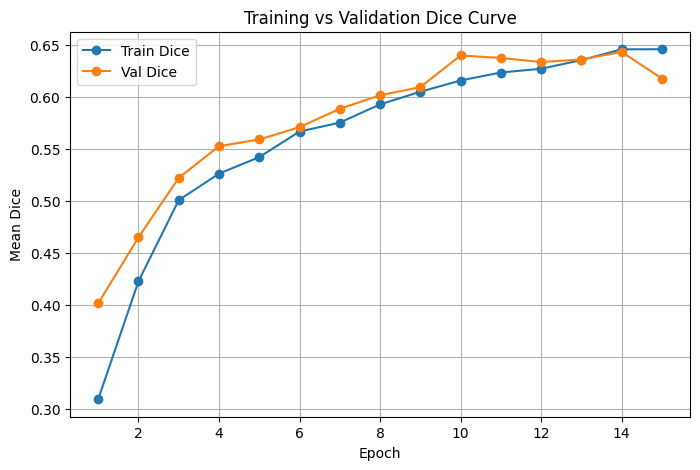

In [2]:
import matplotlib.pyplot as plt

# From your already printed logs

train_dice = [
    0.3090, 0.4224, 0.5005, 0.5260, 0.5419,
    0.5665, 0.5751, 0.5926, 0.6048, 0.6156,
    0.6233, 0.6269, 0.6352, 0.6456, 0.6457
]

val_dice = [
    0.4012, 0.4647, 0.5219, 0.5524, 0.5589,
    0.5707, 0.5884, 0.6014, 0.6092, 0.6397,
    0.6373, 0.6334, 0.6358, 0.6431, 0.6175
]

epochs = range(1, len(train_dice) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_dice, marker='o', label="Train Dice")
plt.plot(epochs, val_dice, marker='o', label="Val Dice")

plt.xlabel("Epoch")
plt.ylabel("Mean Dice")
plt.title("Training vs Validation Dice Curve")
plt.legend()
plt.grid(True)
plt.show()


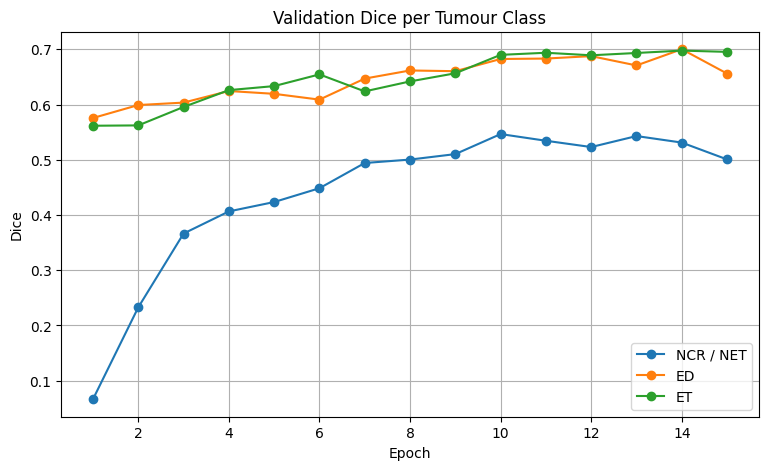

In [3]:
import matplotlib.pyplot as plt

# Val class-wise dice (copied from your already printed logs)

ncr = [0.0663,0.2327,0.3664,0.4065,0.4235,0.4485,0.4942,0.5004,0.5103,0.5466,0.5345,0.5231,0.5430,0.5312,0.5007]
ed  = [0.5757,0.5992,0.6036,0.6246,0.6195,0.6090,0.6471,0.6618,0.6605,0.6826,0.6834,0.6878,0.6709,0.7003,0.6562]
et  = [0.5617,0.5623,0.5957,0.6262,0.6335,0.6547,0.6239,0.6420,0.6567,0.6901,0.6939,0.6893,0.6935,0.6978,0.6955]

epochs = range(1, len(ncr)+1)

plt.figure(figsize=(9,5))
plt.plot(epochs, ncr, marker='o', label="NCR / NET")
plt.plot(epochs, ed,  marker='o', label="ED")
plt.plot(epochs, et,  marker='o', label="ET")

plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Validation Dice per Tumour Class")
plt.legend()
plt.grid(True)
plt.show()


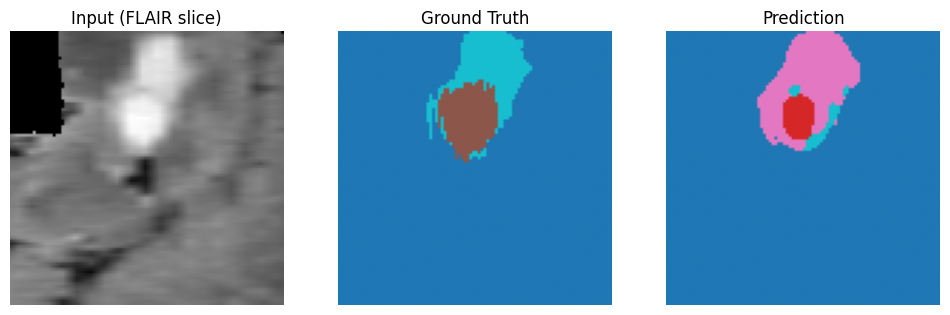

In [4]:
import matplotlib.pyplot as plt
import torch

model.eval()

# ek hi batch uthao
imgs, masks, labels = next(iter(val_loader))

imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    seg_pred, _ = model(imgs)

# first sample
pred = seg_pred.argmax(1)[0].cpu().numpy()
gt   = masks[0].cpu().numpy()

# center slice
z = pred.shape[0] // 2

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(imgs[0,0,z].cpu(), cmap="gray")
plt.title("Input (FLAIR slice)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt[z], cmap="tab10")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[z], cmap="tab10")
plt.title("Prediction")
plt.axis("off")

plt.show()


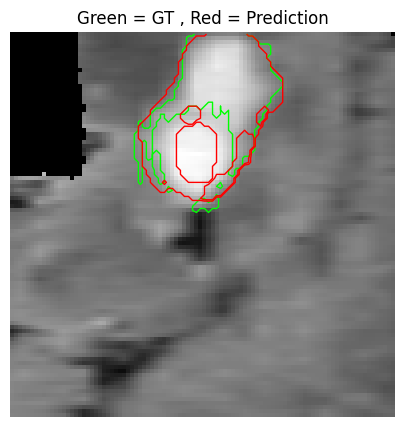

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))

base = imgs[0,0,z].cpu().numpy()
plt.imshow(base, cmap="gray")

# GT contour
plt.contour(gt[z], levels=[1,2,3], colors='lime', linewidths=1)

# Prediction contour
plt.contour(pred[z], levels=[1,2,3], colors='red', linewidths=1)

plt.title("Green = GT , Red = Prediction")
plt.axis("off")
plt.show()


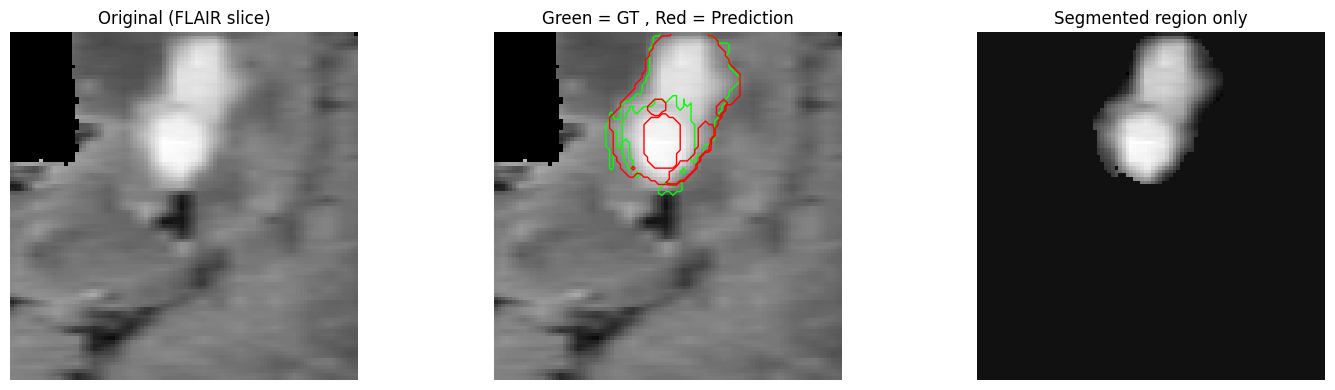

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# already available from your previous cell
# imgs, gt, pred, z

orig = imgs[0,0,z].cpu().numpy()
gt_slice   = gt[z]
pred_slice = pred[z]

# segmented only (all tumour together)
mask = pred_slice > 0
seg_only = np.zeros_like(orig)
seg_only[mask] = orig[mask]

plt.figure(figsize=(15,4))

# -------------------------
# 1. Original
# -------------------------
plt.subplot(1,3,1)
plt.imshow(orig, cmap="gray")
plt.title("Original (FLAIR slice)")
plt.axis("off")

# -------------------------
# 2. Overlay (same as your image)
# -------------------------
plt.subplot(1,3,2)
plt.imshow(orig, cmap="gray")
plt.contour(gt_slice,   levels=[1,2,3], colors='lime', linewidths=1)
plt.contour(pred_slice,levels=[1,2,3], colors='red',  linewidths=1)
plt.title("Green = GT , Red = Prediction")
plt.axis("off")

# -------------------------
# 3. Segmented only
# -------------------------
plt.subplot(1,3,3)
plt.imshow(seg_only, cmap="gray")
plt.title("Segmented region only")
plt.axis("off")

plt.tight_layout()
plt.show()


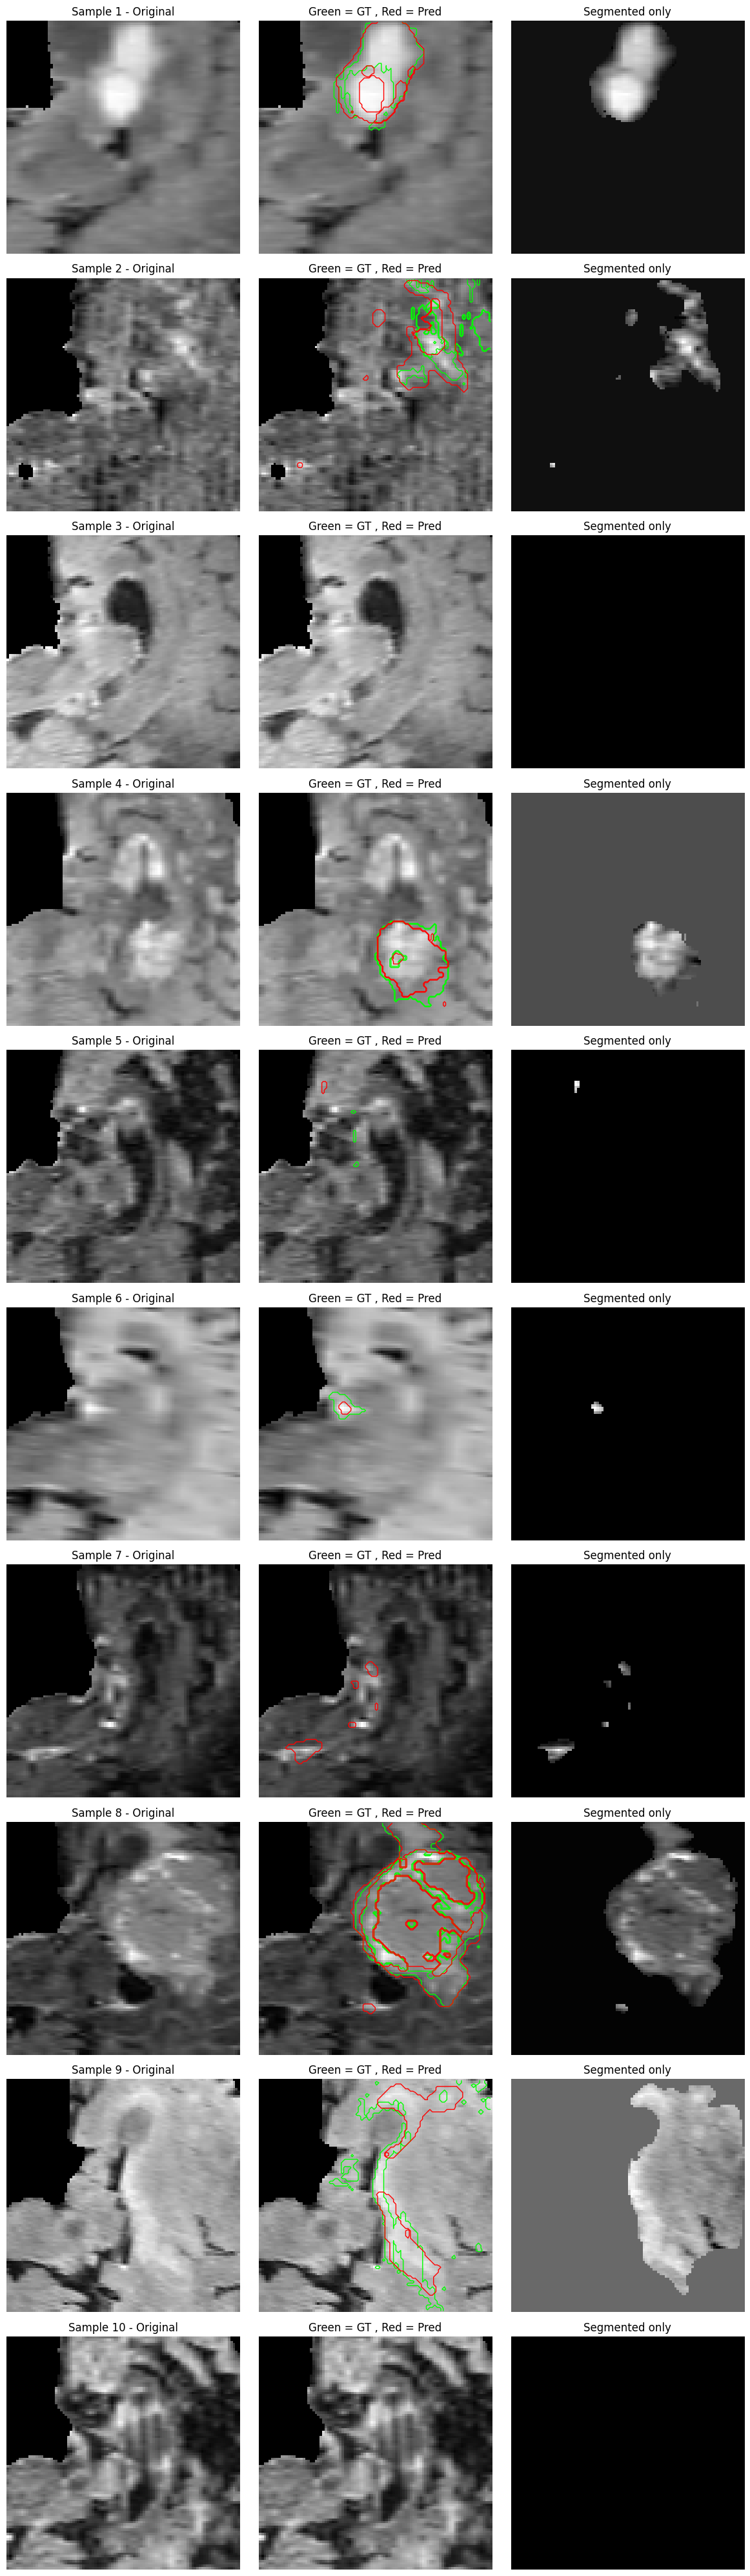

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

num_show = 10
shown = 0

fig, axes = plt.subplots(num_show, 3, figsize=(12, 4*num_show))

with torch.no_grad():

    for imgs, masks, _ in val_loader:

        imgs  = imgs.to(device)
        masks = masks.to(device)

        seg_pred, _ = model(imgs)
        seg_pred = seg_pred.argmax(1)

        B = imgs.shape[0]

        for b in range(B):

            if shown >= num_show:
                break

            orig = imgs[b, 0].cpu().numpy()     # FLAIR
            gt   = masks[b].cpu().numpy()
            pred = seg_pred[b].cpu().numpy()

            z = orig.shape[0] // 2

            pred_slice = pred[z]
            gt_slice   = gt[z]
            orig_slice = orig[z]

            # segmented only
            mask = pred_slice > 0
            seg_only = np.zeros_like(orig_slice)
            seg_only[mask] = orig_slice[mask]

            # -----------------------
            # 1. Original
            # -----------------------
            axes[shown, 0].imshow(orig_slice, cmap="gray")
            axes[shown, 0].set_title(f"Sample {shown+1} - Original")
            axes[shown, 0].axis("off")

            # -----------------------
            # 2. Overlay
            # -----------------------
            axes[shown, 1].imshow(orig_slice, cmap="gray")
            axes[shown, 1].contour(gt_slice,   levels=[1,2,3], colors='lime', linewidths=1)
            axes[shown, 1].contour(pred_slice, levels=[1,2,3], colors='red',  linewidths=1)
            axes[shown, 1].set_title("Green = GT , Red = Pred")
            axes[shown, 1].axis("off")

            # -----------------------
            # 3. Segmented only
            # -----------------------
            axes[shown, 2].imshow(seg_only, cmap="gray")
            axes[shown, 2].set_title("Segmented only")
            axes[shown, 2].axis("off")

            shown += 1

        if shown >= num_show:
            break

plt.tight_layout()
plt.show()
